<a href="https://colab.research.google.com/github/microprediction/timeseries-notebooks/blob/main/pytorch_forecasting_hello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-forecasting

# NOT quite done yet


In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.examples import get_stallion_data
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
!pip install microprediction

# Hello world example
See https://www.microprediction.com/blog/popular-timeseries-packages for more packages

In [3]:
from microprediction import MicroReader
mr = MicroReader()
YS = mr.get_lagged_values(name='emojitracker-twitter-face_with_medical_mask.json')[:200]

In [6]:
import pytorch_lightning as pl
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

def run(ys):
        """ Apply model to univariate time series
        # Not really the strength of this library but why not?
        :param ys:       Vector of observations
        :param theta:    Unused (at present) parameters or hyper-params
        :return:         Vector of predictions
        """
        burnin = len(ys)
        data = pd.DataFrame(columns=['y'],data=ys[:burnin])
        data["time_idx"] = list(range(burnin))
        data["group_id"] = ["same" for _ in range(burnin)]
        max_prediction_length = 1
        max_encoder_length = 24
        training_cutoff = data["time_idx"].max() - max_prediction_length
        training = TimeSeriesDataSet(
            data[lambda x: x.time_idx <= training_cutoff],
            time_idx="time_idx",
            target="y",
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
            group_ids=["group_id"]
        )
        validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
        batch_size = 128  # set this between 32 to 128
        train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
        val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

        pl.seed_everything(42)
        trainer = pl.Trainer(
            gpus=0,
            # clipping gradients is a hyperparameter and important to prevent divergance
            # of the gradient for recurrent neural networks
            gradient_clip_val=0.1,
        )

        tft = TemporalFusionTransformer.from_dataset(
            training,
            # not meaningful for finding the learning rate but otherwise very important
            learning_rate=0.03,
            hidden_size=16,  # most important hyperparameter apart from learning rate
            # number of attention heads. Set to up to 4 for large datasets
            attention_head_size=1,
            dropout=0.1,  # between 0.1 and 0.3 are good values
            hidden_continuous_size=8,  # set to <= hidden_size
            output_size=7,  # 7 quantiles by default
            loss=QuantileLoss(),
            # reduce learning rate if no improvement in validation loss after x epochs
            reduce_on_plateau_patience=4,
        )
        print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")
        # find optimal learning rate
        res = trainer.tuner.lr_find(
            tft,
            train_dataloader=train_dataloader,
            val_dataloaders=val_dataloader,
            max_lr=10.0,
            min_lr=1e-6,
        )

        # configure network and trainer
        early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
        lr_logger = LearningRateMonitor()  # log the learning rate

        trainer = pl.Trainer(
            max_epochs=30,
            gpus=0,
            weights_summary="top",
            gradient_clip_val=0.1,
            limit_train_batches=30,  # coment in for training, running valiation every 30 batches
            # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
            callbacks=[lr_logger, early_stop_callback],
            logger=TensorBoardLogger("lightning_logs"),
        )

        tft = TemporalFusionTransformer.from_dataset(
            training,
            learning_rate=0.03,
            hidden_size=16,
            attention_head_size=1,
            dropout=0.1,
            hidden_continuous_size=8,
            output_size=7,  # 7 quantiles by default
            loss=QuantileLoss(),
            log_interval=10,
            # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
            reduce_on_plateau_patience=4,
        )
        print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")
        trainer.fit(
            tft,
            train_dataloader=train_dataloader,
            val_dataloaders=val_dataloader,
        )

        # load the best model according to the validation loss
        # (given that we use early stopping, this is not necessarily the last epoch)
        best_model_path = trainer.checkpoint_callback.best_model_path
        best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

        # ----------------------------------------------------
        # Out of sample ... (this is wrong ... need to fix it)
        encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]
        last_data = data[lambda x: x.time_idx == x.time_idx.max()]
        decoder_data = pd.concat(
            [last_data for i in range(1, max_prediction_length + 1)],
            ignore_index=True,
        )
        num_decoder = len(decoder_data)
        decoder_data["time_idx"] = list(range(num_decoder))
        # combine encoder and decoder data
        new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
        new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

        return ys


XS = run(YS)
len(XS)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_varia

Number of parameters in network: 17.0k


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_varia

Number of parameters in network: 17.0k


/usr/local/lib/python3.6/dist-packages/pytorch_forecasting/data/timeseries.py:774: UserWarning:

If predicting, no randomization should be possible - setting stop_randomization=True



AssertionError: ignored

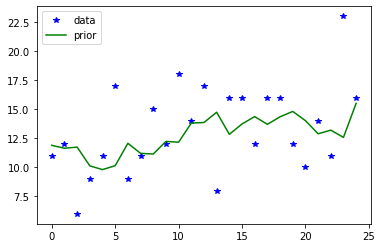

In [ ]:
import matplotlib.pyplot as plt
plt.plot(YS[125:150],'*b')
plt.plot(XS[125:150],'g')
plt.legend(['data','prior'])